In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow import nn
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from joblib import dump, load
import pickle
from tensorflow.python.keras.saving import saving_utils
from tensorflow.python.keras.layers import deserialize, serialize
import seaborn as sns
import time 

from statistics import mean, variance, pstdev
from scipy.spatial import distance
from scipy.stats import wilcoxon

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Data

In [ ]:
seq_len = 288
n_seq = 2
hidden_dim = 128
gamma = 1

noise_dim = 32
dim = 128
batch_size = 54

log_step = 100
learning_rate = 5e-4
train_steps = 1000

gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

In [ ]:
df_575 =  pd.read_csv('/content/drive/MyDrive/Thesis/processed data/575.csv')

In [ ]:
df_575 = df_575.drop(['time'], axis=1)

In [ ]:
len(df_575)

15552

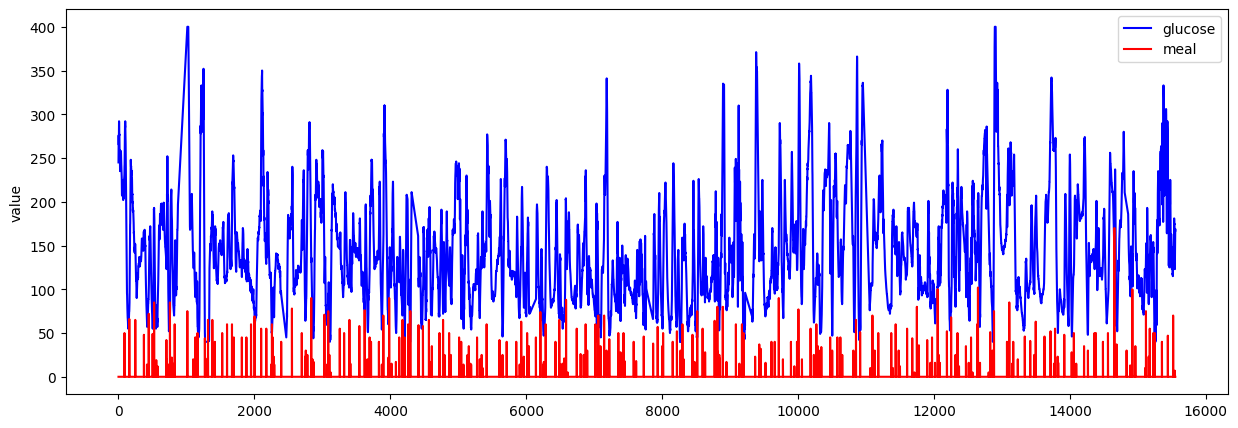

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_575['glucose_value'], 'b', label='glucose')
plt.plot(df_575['meal_value'], 'r', label='meal')

plt.ylabel("value")
plt.legend()

plt.show()

#Preprocess

In [ ]:
# preprocess training data
ori_575 = df_575
scaler = MinMaxScaler().fit(ori_575)
ori_575 = scaler.transform(ori_575)

index = [(0 + 288 * i) for i in range(54)]
training_575 = []
for i in index:
  x = ori_575[i:i + seq_len]
  training_575.append(x)

#Modules

In [ ]:
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(**saving_utils.compile_args_from_training_config(training_config))
    restored_model.set_weights(weights)
    return restored_model

In [ ]:
def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

In [ ]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'gru_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'lstm_{i + 1}'))

    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='out'))
    return model

In [ ]:
class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model

In [ ]:
class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model

In [ ]:
class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery

In [ ]:
class Embedder(Model):

    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder

In [ ]:
# generate the next sequence using the previous sequence

class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model

<h1 id="definitions" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;"> 
    <center>Definitions
        <a class="anchor-link" href="#definitions" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        # AutoEncoder
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        
        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        # Adversarial Supervise Architecture

        # from random noise -> embedding
        E_Hat = self.generator_aux(Z)
        # generate the next embedding sequence from the previous one
        H_hat = self.supervisor(E_Hat)
        # discriminate the generated next embedding and the real next embedding (supervised)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')

        
        # Adversarial architecture in latent space

        # discriminate the real embedding and the generated embedding (unsupervised)
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')
        
        #Synthetic data generation
        X_hat = self.recovery(H_hat)
        
        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')

        
        # Final discriminator model
        Y_real = self.discriminator(H)
        
        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        # Loss functions
        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()

        

        return self.generator_aux, self.discriminator, self.supervisor, self.recovery, self.embedder

<h1 id="trainingModules" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;"> 
    <center>Training Modules
        <a class="anchor-link" href="#trainingModules" target="_self">¶</a>
    </center>
</h1>

In [ ]:
data = convert_to_tensor(training_575, dtype=float32)
real_series = (tfdata.Dataset.from_tensor_slices(data)
                .shuffle(buffer_size=len(training_575))
                .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [ ]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)
    
    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss


    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=128, seq_len=seq_len, n_seq=n_seq, gamma=1)

<h1 id="training" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [ ]:
autoencoder_opt = Adam(learning_rate=learning_rate)
e_auto_loss = []
for step in tqdm(range(1000), desc='Emddeding network training'):
   
    X_ = next(real_series_iter) 
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)
    e_auto_loss.append(step_e_loss_t0.numpy())

Emddeding network training: 100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


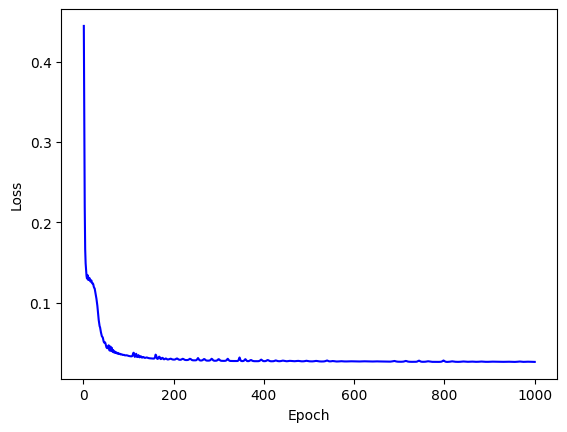

In [ ]:
epoch_num = [i+1 for i in range(len(e_auto_loss))]
plt.plot(epoch_num, e_auto_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
supervisor_opt = Adam(learning_rate=learning_rate)
g_s_loss = []
for step in tqdm(range(1000), desc='Supervised network training'):
  
    X_ = next(real_series_iter)  
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)
    g_s_loss.append(step_g_loss_s.numpy())

Supervised network training: 100%|██████████| 1000/1000 [00:33<00:00, 29.83it/s]


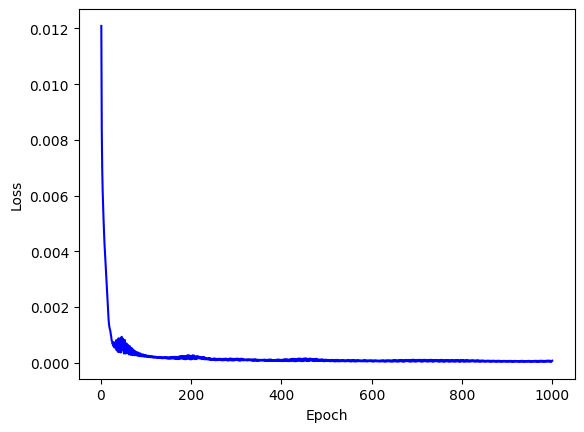

In [ ]:
epoch_num = [i+1 for i in range(len(g_s_loss))]
plt.plot(epoch_num, g_s_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
generator_opt = Adam(learning_rate=learning_rate)
embedder_opt = Adam(learning_rate=learning_rate)
discriminator_opt = Adam(learning_rate=learning_rate)

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
g_loss_u = []
g_loss_s = []
g_loss_v = []
e_loss = []
d_loss = []

for step in tqdm(range(30000), desc='Joint networks training'):
    #Train the generator (k times as often as the discriminator)
    # Here k=2
    for _ in range(2):
        
        X_ = next(real_series_iter)
        Z_ = next(synth.get_batch_noise())
        
        # Train the generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(real_series_iter)
    Z_ = next(synth.get_batch_noise())


    step_d_loss = synth.discriminator_loss(X_, Z_)
    g_loss_u.append(step_g_loss_u.numpy())
    g_loss_s.append(step_g_loss_s.numpy())
    g_loss_v.append(step_g_loss_v.numpy())
    e_loss.append(step_e_loss_t0.numpy())
    d_loss.append(step_d_loss.numpy())
    
    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

    if step % 1000 == 0:
      if step == 0:
        continue
      else:
        make_keras_picklable()
        with open('/content/drive/MyDrive/Thesis/model/timegan/575_128/575_GRU_' +str(step)+ '.pkl', 'wb') as f:
          pickle.dump(synth, f)

        pd.DataFrame(g_loss_u).to_csv('/content/drive/MyDrive/Thesis/loss/generator_u/timegan_g_loss_u_575_128.csv', index=False)
        pd.DataFrame(g_loss_s).to_csv('/content/drive/MyDrive/Thesis/loss/generator_s/timegan_g_loss_s_575_128.csv', index=False)
        pd.DataFrame(g_loss_v).to_csv('/content/drive/MyDrive/Thesis/loss/generator_v/timegan_g_loss_v_575_128.csv', index=False)
        pd.DataFrame(e_loss).to_csv('/content/drive/MyDrive/Thesis/loss/embedder/timegan_e_loss_575_128.csv', index=False)
        pd.DataFrame(d_loss).to_csv('/content/drive/MyDrive/Thesis/loss/discriminator/timegan_d_loss_575_128.csv', index=False)

    if step % 1000 == 0:
      if step == 0:
        continue
      else:
        print(f'{step:6.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
           f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

Joint networks training:   3%|▎         | 1001/30000 [20:51<21:58:14,  2.73s/it]

  1000 | d_loss: 0.8481 | g_loss_u: 1.7807 | g_loss_s: 0.0011 | g_loss_v: 0.0327 | e_loss_t0: 0.0028


Joint networks training:   7%|▋         | 2001/30000 [40:41<10:37:22,  1.37s/it]

  2000 | d_loss: 0.4788 | g_loss_u: 3.4854 | g_loss_s: 0.0013 | g_loss_v: 0.0404 | e_loss_t0: 0.0022


Joint networks training:  10%|█         | 3001/30000 [1:00:34<10:01:16,  1.34s/it]

  3000 | d_loss: 0.4176 | g_loss_u: 4.1276 | g_loss_s: 0.0012 | g_loss_v: 0.0345 | e_loss_t0: 0.0019


Joint networks training:  13%|█▎        | 4001/30000 [1:20:30<9:42:06,  1.34s/it]

  4000 | d_loss: 0.3875 | g_loss_u: 4.1104 | g_loss_s: 0.0011 | g_loss_v: 0.0474 | e_loss_t0: 0.0016


Joint networks training:  17%|█▋        | 5001/30000 [1:40:26<9:24:07,  1.35s/it]

  5000 | d_loss: 0.3700 | g_loss_u: 5.0684 | g_loss_s: 0.0011 | g_loss_v: 0.0340 | e_loss_t0: 0.0014


Joint networks training:  20%|██        | 6001/30000 [2:00:22<9:00:16,  1.35s/it]

  6000 | d_loss: 0.3600 | g_loss_u: 4.8064 | g_loss_s: 0.0011 | g_loss_v: 0.0324 | e_loss_t0: 0.0013


Joint networks training:  23%|██▎       | 7001/30000 [2:20:15<8:49:28,  1.38s/it]

  7000 | d_loss: 0.4561 | g_loss_u: 4.9071 | g_loss_s: 0.0010 | g_loss_v: 0.0332 | e_loss_t0: 0.0013


Joint networks training:  27%|██▋       | 8001/30000 [2:40:11<8:12:57,  1.34s/it]

  8000 | d_loss: 0.3890 | g_loss_u: 5.1467 | g_loss_s: 0.0010 | g_loss_v: 0.0355 | e_loss_t0: 0.0011


Joint networks training:  30%|███       | 9001/30000 [3:00:09<7:56:02,  1.36s/it]

  9000 | d_loss: 0.3556 | g_loss_u: 6.3637 | g_loss_s: 0.0009 | g_loss_v: 0.0394 | e_loss_t0: 0.0011


Joint networks training:  33%|███▎      | 10001/30000 [3:20:00<7:33:05,  1.36s/it]

 10000 | d_loss: 0.2858 | g_loss_u: 5.7940 | g_loss_s: 0.0009 | g_loss_v: 0.0335 | e_loss_t0: 0.0010


Joint networks training:  37%|███▋      | 11001/30000 [3:40:01<7:12:20,  1.37s/it]

 11000 | d_loss: 0.4719 | g_loss_u: 5.2212 | g_loss_s: 0.0008 | g_loss_v: 0.0392 | e_loss_t0: 0.0010


Joint networks training:  40%|████      | 12001/30000 [4:00:03<6:52:31,  1.38s/it]

 12000 | d_loss: 0.3090 | g_loss_u: 6.1388 | g_loss_s: 0.0010 | g_loss_v: 0.0315 | e_loss_t0: 0.0009


Joint networks training:  43%|████▎     | 13001/30000 [4:19:58<6:23:15,  1.35s/it]

 13000 | d_loss: 0.2373 | g_loss_u: 7.2674 | g_loss_s: 0.0009 | g_loss_v: 0.0344 | e_loss_t0: 0.0020


Joint networks training:  47%|████▋     | 14001/30000 [4:40:00<6:05:49,  1.37s/it]

 14000 | d_loss: 0.3253 | g_loss_u: 6.0063 | g_loss_s: 0.0009 | g_loss_v: 0.0367 | e_loss_t0: 0.0009


Joint networks training:  50%|█████     | 15001/30000 [4:59:53<5:43:07,  1.37s/it]

 15000 | d_loss: 0.2721 | g_loss_u: 5.9191 | g_loss_s: 0.0010 | g_loss_v: 0.0492 | e_loss_t0: 0.0009


Joint networks training:  53%|█████▎    | 16001/30000 [5:19:54<5:22:43,  1.38s/it]

 16000 | d_loss: 0.3897 | g_loss_u: 5.4398 | g_loss_s: 0.0009 | g_loss_v: 0.0363 | e_loss_t0: 0.0008


Joint networks training:  57%|█████▋    | 17001/30000 [5:39:44<4:57:40,  1.37s/it]

 17000 | d_loss: 0.4266 | g_loss_u: 5.8122 | g_loss_s: 0.0008 | g_loss_v: 0.0351 | e_loss_t0: 0.0008


Joint networks training:  60%|██████    | 18001/30000 [5:59:45<4:38:16,  1.39s/it]

 18000 | d_loss: 0.1983 | g_loss_u: 6.0830 | g_loss_s: 0.0008 | g_loss_v: 0.0394 | e_loss_t0: 0.0010


Joint networks training:  63%|██████▎   | 19001/30000 [6:19:35<4:12:34,  1.38s/it]

 19000 | d_loss: 0.2628 | g_loss_u: 6.1648 | g_loss_s: 0.0008 | g_loss_v: 0.0354 | e_loss_t0: 0.0008


Joint networks training:  67%|██████▋   | 20001/30000 [6:39:04<3:50:11,  1.38s/it]

 20000 | d_loss: 0.1754 | g_loss_u: 5.9335 | g_loss_s: 0.0008 | g_loss_v: 0.0403 | e_loss_t0: 0.0007


Joint networks training:  70%|███████   | 21001/30000 [6:58:05<3:12:04,  1.28s/it]

 21000 | d_loss: 0.1311 | g_loss_u: 6.6764 | g_loss_s: 0.0007 | g_loss_v: 0.0280 | e_loss_t0: 0.0008


Joint networks training:  73%|███████▎  | 22001/30000 [7:16:54<3:00:28,  1.35s/it]

 22000 | d_loss: 0.2563 | g_loss_u: 5.4634 | g_loss_s: 0.0008 | g_loss_v: 0.0370 | e_loss_t0: 0.0008


Joint networks training:  77%|███████▋  | 23001/30000 [7:36:33<2:38:03,  1.35s/it]

 23000 | d_loss: 0.1550 | g_loss_u: 6.4196 | g_loss_s: 0.0008 | g_loss_v: 0.0352 | e_loss_t0: 0.0015


Joint networks training:  80%|████████  | 24001/30000 [7:55:10<2:12:12,  1.32s/it]

 24000 | d_loss: 0.1483 | g_loss_u: 6.3181 | g_loss_s: 0.0008 | g_loss_v: 0.0346 | e_loss_t0: 0.0015


Joint networks training:  83%|████████▎ | 25001/30000 [8:13:40<1:50:12,  1.32s/it]

 25000 | d_loss: 0.1494 | g_loss_u: 7.1207 | g_loss_s: 0.0008 | g_loss_v: 0.0418 | e_loss_t0: 0.0006


Joint networks training:  87%|████████▋ | 26001/30000 [8:32:27<1:26:46,  1.30s/it]

 26000 | d_loss: 0.1350 | g_loss_u: 6.2053 | g_loss_s: 0.0007 | g_loss_v: 0.0314 | e_loss_t0: 0.0007


Joint networks training:  90%|█████████ | 27001/30000 [8:50:25<1:04:28,  1.29s/it]

 27000 | d_loss: 0.1357 | g_loss_u: 5.2865 | g_loss_s: 0.0007 | g_loss_v: 0.0550 | e_loss_t0: 0.0006


Joint networks training:  93%|█████████▎| 28001/30000 [9:08:35<44:17,  1.33s/it]

 28000 | d_loss: 0.1405 | g_loss_u: 6.2313 | g_loss_s: 0.0007 | g_loss_v: 0.0350 | e_loss_t0: 0.0006


Joint networks training:  97%|█████████▋| 29001/30000 [9:26:49<21:50,  1.31s/it]

 29000 | d_loss: 0.1433 | g_loss_u: 6.4675 | g_loss_s: 0.0006 | g_loss_v: 0.0287 | e_loss_t0: 0.0005


Joint networks training: 100%|██████████| 30000/30000 [9:44:52<00:00,  1.17s/it]


In [ ]:
make_keras_picklable()
with open('/content/drive/MyDrive/Thesis/model/timegan/575_128/575_GRU_30000.pkl', 'wb') as f:
  pickle.dump(synth, f)

In [ ]:
d_loss = pd.read_csv('/content/drive/MyDrive/Thesis/loss/discriminator/timegan_d_loss_575_128.csv')
g_loss_u = pd.read_csv('/content/drive/MyDrive/Thesis/loss/generator_u/timegan_g_loss_u_575_128.csv')
g_loss_s = pd.read_csv('/content/drive/MyDrive/Thesis/loss/generator_s/timegan_g_loss_s_575_128.csv')
g_loss_v = pd.read_csv('/content/drive/MyDrive/Thesis/loss/generator_v/timegan_g_loss_v_575_128.csv')
e_loss = pd.read_csv('/content/drive/MyDrive/Thesis/loss/embedder/timegan_e_loss_575_128.csv')

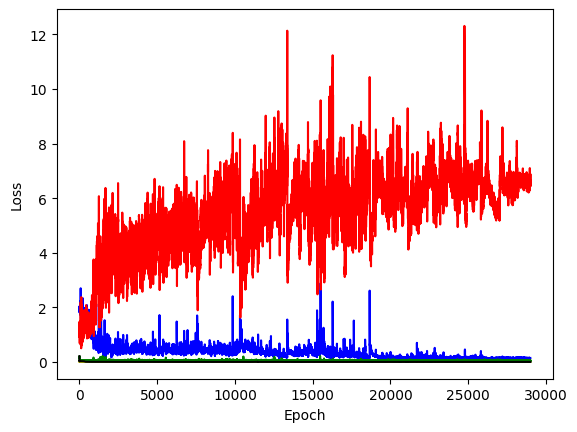

In [ ]:
epoch_num = [i+1 for i in range(len(d_loss))]
plt.plot(epoch_num, d_loss, 'b')
plt.plot(epoch_num, g_loss_u, 'r')
plt.plot(epoch_num, g_loss_s, 'y')
plt.plot(epoch_num, g_loss_v, 'g')
plt.plot(epoch_num, e_loss, 'black')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Analysis

Generate synthetic data

In [ ]:
# generate synthetic data by all trained models

synth_list = []
for i in tqdm(range(1,30)):
  with open('/content/drive/MyDrive/Thesis/model/timegan/575_128/575_GRU_' +str(i*1000)+ '.pkl' , 'rb') as f:
    synth = pickle.load(f)

  sub_synth_list = []
  for j in range(6):

    synth_data = synth.sample(54)
    sub_synth_list.append(synth_data)

  synth_list.append(sub_synth_list)

In [ ]:
np.save("/content/drive/MyDrive/Thesis/best model/timegan_575_128/synthetic_data.npy",synth_list)

In [ ]:
synth_list = np.load("/content/drive/MyDrive/Thesis/best model/timegan_575_128/synthetic_data.npy")

In [ ]:
for i in range(len(synth_list)):
  # i:30
  for j in range(len(synth_list[0])):
    # j:6
    for k in range(len(synth_list[0][0])):
      # k:110
      synth_list[i][j][k] = scaler.inverse_transform(synth_list[i][j][k])

In [ ]:
np.save("/content/drive/MyDrive/Thesis/best model/timegan_575_128/synthetic_data_nonorm.npy",synth_list)

In [ ]:
# statistical metrics calculation
mean_list = []
std_list = []
hyper_list = []
tir_list = []
l1_list = []
l2_list = []
for i in tqdm(range(len(synth_list))):
  # i:30
  
  for j in range(len(synth_list[0])):
    # j:6

    value = [] #all the glucose values from 55 days
    sub_mean = []
    sub_std = []
    hyper = []
    tir = []
    l1 = []
    l2 = []
    for k in range(54):
      # k:the first 49
      value = value + synth_list[i][j][k][:, 0].tolist()
    sub_mean.append(mean(value)) # mean glucose values from the 49 days
    sub_std.append(pstdev(value))

    extracted_hyper = np.extract((np.array(value) >= 180), (np.array(value)))
    hyper.append(extracted_hyper.shape[0] / (288*54))
    extracted_tir = np.extract((np.array(value) < 180) & (np.array(value) >= 70), np.array(value))
    tir.append(extracted_tir.shape[0] / (288*54))
    extracted_l1 = np.extract((np.array(value) < 70) & ((np.array(value) >= 54)), np.array(value))
    l1.append(extracted_l1.shape[0] / (288*54))
    extracted_l2 = np.extract((np.array(value) < 54), np.array(value))
    l2.append(extracted_l2.shape[0] / (288*54))


  mean_list.append(mean(sub_mean))
  std_list.append(mean(sub_std))
  hyper_list.append(mean(hyper))
  tir_list.append(mean(tir))
  l1_list.append(mean(l1))
  l2_list.append(mean(l2))

100%|██████████| 29/29 [00:04<00:00,  6.19it/s]


In [ ]:
df_575_result = pd.DataFrame(list(zip(hyper_list, tir_list, l1_list, l2_list, mean_list, std_list)), columns = ['Hyper', 'TIR', 'L1 Hypo', 'L2 Hypo', 'Mean', 'SD'])
df_575_result

,Hyper,TIR,L1 Hypo,L2 Hypo,Mean,SD
0,0.513439,0.482896,0.002572,0.001093,150.511333,59.674445
1,0.518326,0.308963,0.172711,0.000000,150.284870,61.647381
2,0.451260,0.207433,0.334491,0.006816,132.945603,61.932856
3,0.252251,0.729681,0.015754,0.002315,155.127906,64.723295
4,0.364776,0.635159,0.000064,0.000000,140.171246,61.613201
5,0.338863,0.659851,0.001286,0.000000,162.505797,68.160416
6,0.228459,0.771541,0.000000,0.000000,136.197809,61.020488
7,0.225116,0.774884,0.000000,0.000000,135.489793,60.116661
8,0.398212,0.597029,0.004758,0.000000,142.241177,59.505042
9,0.259581,0.685057,0.051440,0.003922,158.343603,71.576809


In [ ]:
# save unnormalized synthetic data
np.save("/content/drive/MyDrive/Thesis/best model/timegan_559_128/synthetic_data_nonorm.npy",synth_list)

In [ ]:
# unormalized original data
for i in range(len(training_575)):
  training_575[i] = scaler.inverse_transform(training_575[i])

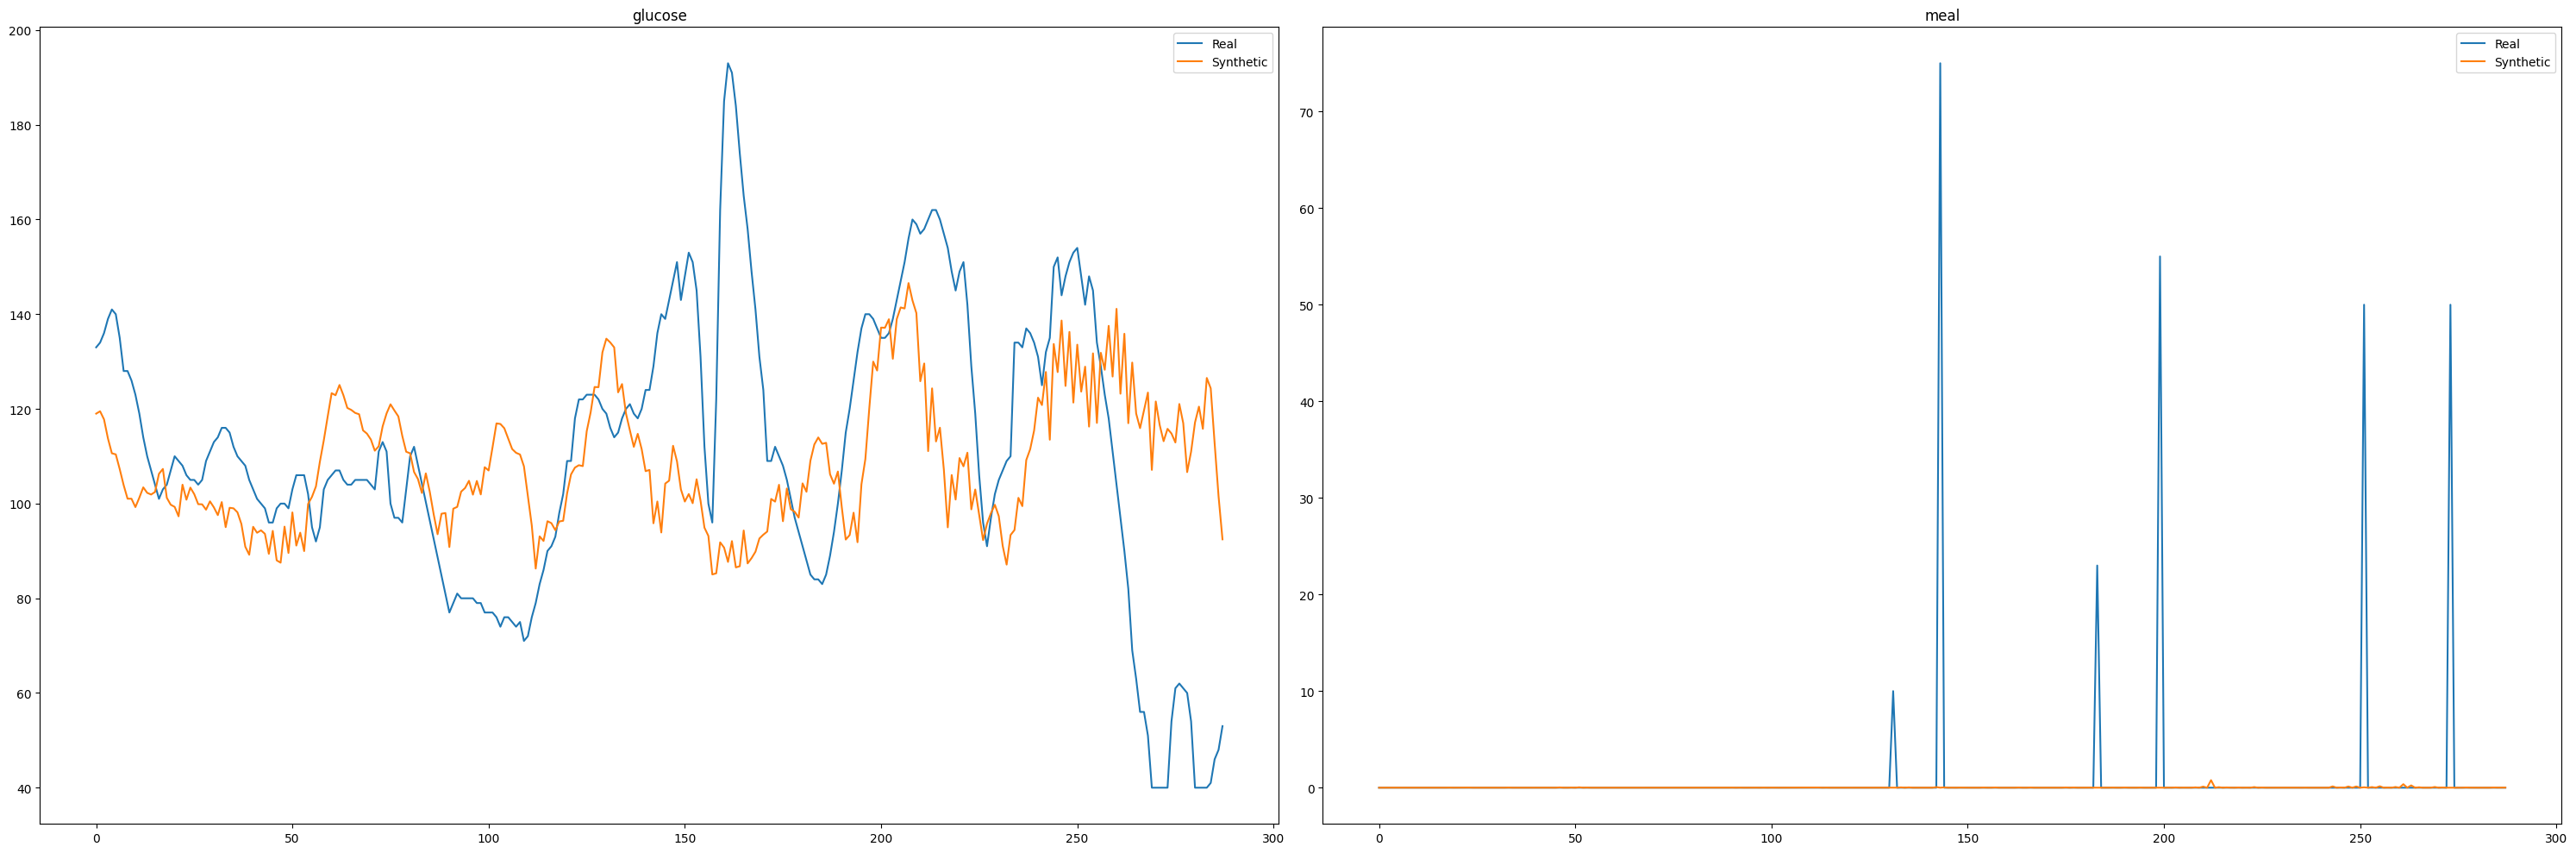

In [ ]:
cols = ['glucose','meal']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
axes=axes.flatten()

time = list(range(1,25))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': training_575[52][:, j], 'Synthetic': synth_list[7][0][52][:, j]})
    #df = pd.DataFrame({'Real': temp_test[0][:, j], 'Synthetic': synth_data_all[19][3][:, j], 'Synthetic_2': synth_data_all[19][15][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-'])
fig.tight_layout()